In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from utils import read_air_passengers_csv, train_val_test_split
from utils_lstm import LSTMNet

YEAR_CUTOFFS = [1940, 1956, 1960]

In [2]:
df = read_air_passengers_csv()
df_train, df_val, df_test = train_val_test_split(df, YEAR_CUTOFFS)

# Transform from pandas dataframe to numpy array of shape (n, 1)
train = df_train[['#Passengers']].astype('float32').values
val = df_val[['#Passengers']].astype('float32').values

mu, std = train.mean(), train.std()
train_norm = (train - mu)/std
val_norm = (val - mu)/std

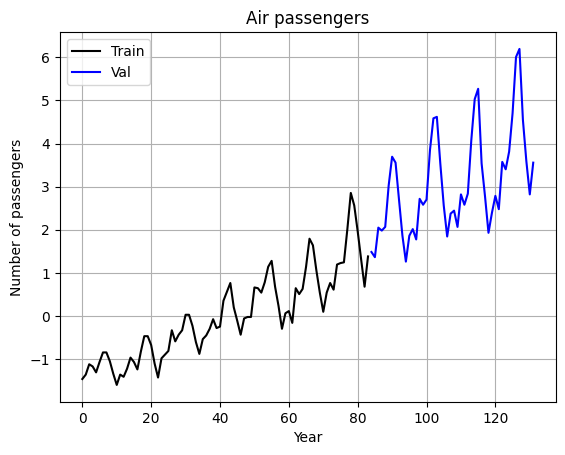

In [3]:
plt.title('Air passengers')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.plot(train_norm, color='k', label='Train')
plt.plot(np.arange(len(train_norm), len(train_norm)+len(val_norm)), val_norm, color='b', label='Val')

plt.grid()
plt.legend()
plt.show()

In [4]:
# Constants

look_back = 1
recurrent_size = 50
n_layers = 1

batch_size = 8

n_epochs = 2000
n_epochs_val = n_epochs / 10

In [5]:
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        feature = data[i:i+look_back]
        target = data[[i+look_back]]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [6]:
X_train, y_train = create_dataset(data=train_norm,
                                  look_back=look_back)
X_val, y_val = create_dataset(data=val_norm,
                                  look_back=look_back)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([83, 1, 1]) torch.Size([83, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


C:\Users\lopezmel\AppData\Local\Temp\ipykernel_21068\2762127291.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X), torch.tensor(y)


In [7]:
train_dataloader = DataLoader(dataset=TensorDataset(X_train, y_train),
                              batch_size=batch_size,
                              shuffle=True)

model = LSTMNet(dim_input=1,
                dim_recurrent=recurrent_size,
                num_layers=n_layers,
                dim_output=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(1, n_epochs + 1):
    # Set model to train mode
    model.train()
    for features, targets in train_dataloader:
        outputs = model(features)
        loss = criterion(outputs, targets)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % n_epochs_val == 0:
        # Set model to eval mode, and disable autograd
        model.eval()
        with torch.no_grad():
            rmse_train = np.sqrt(criterion(model(X_train)*std + mu, y_train*std + mu))
            rmse_val = np.sqrt(criterion(model(X_val)*std + mu, y_val*std + mu))
            print(f'Epoch {epoch}: RMSE_train = {rmse_train:.2f}, RMSE_val = {rmse_val:.2f}')

torch.Size([8, 1, 1])


c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([83, 1, 1])) that is different to the

Epoch 200: RMSE_train = 58.36, RMSE_val = 176.87
Epoch 400: RMSE_train = 58.45, RMSE_val = 173.92
Epoch 600: RMSE_train = 58.32, RMSE_val = 174.61
Epoch 800: RMSE_train = 58.44, RMSE_val = 173.20
Epoch 1000: RMSE_train = 58.55, RMSE_val = 169.14
Epoch 1200: RMSE_train = 58.50, RMSE_val = 170.47
Epoch 1400: RMSE_train = 58.36, RMSE_val = 176.01
Epoch 1600: RMSE_train = 58.39, RMSE_val = 174.01
Epoch 1800: RMSE_train = 58.39, RMSE_val = 172.37
Epoch 2000: RMSE_train = 58.41, RMSE_val = 172.75


In [8]:
preds = []

model.eval()
with torch.no_grad():
    for i in range(len(train_norm)-look_back):
        X_last = torch.tensor(train_norm[i:i+look_back]).unsqueeze(0)
        new_pred = model(X_last)
        # Store only the value
        preds.append(new_pred.item())
    # X_last = torch.tensor(train_norm[-look_back:]).unsqueeze(0)
    for i in range(len(val_norm)):
        new_pred = model(X_last)
        # Store only the value
        preds.append(new_pred.item())
        # Pass the tensor for next prediction
        X_last = torch.cat((X_last[:, -look_back+1:, :], new_pred.unsqueeze(0)), dim=1)

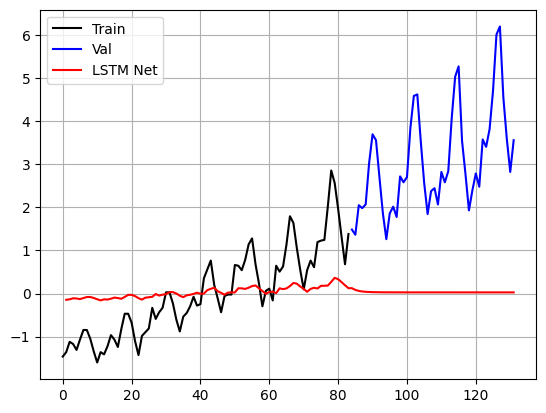

In [9]:
x_ticks_val = np.arange(len(train_norm), len(train_norm)+len(val_norm))
x_ticks_preds = np.arange(1, len(train_norm)+len(val_norm))

plt.plot(train_norm, c='k', label='Train')
plt.plot(x_ticks_val, val_norm, c='b', label='Val')
plt.plot(x_ticks_preds, preds, c='r', label='LSTM Net')
plt.grid()
plt.legend()
plt.show()